In [1]:
!date

Wed Jul 30 10:12:25 PM EDT 2025


In [2]:
pwd

'/projects/sccn/andromeda1/aglinska/BC-ABCD-denoise/Code'

### Get Files

In [3]:
import os
import numpy as np
import pandas as pd
import ants

In [4]:
import importlib

import DeepCor_utils
importlib.reload(DeepCor_utils)

import DeepCor_models
importlib.reload(DeepCor_models)

from DeepCor_utils import *
from DeepCor_models import *

numpy version: 1.20.1
sklearn version: 1.3.2
torch version: 2.4.1+cu121
AntsPy version: 0.6.1
numpy version: 1.20.1
sklearn version: 1.3.2
torch version: 2.4.1+cu121
AntsPy version: 0.6.1


In [5]:
indir = '../Data/StudyForrest/fmriprep/'
subs = [s for s in os.listdir(indir) if all((s.startswith('sub'),not s.endswith('.html')))]
subs.sort()
#print(f'{len(subs)}/{len(subs_orig)}')
print(len(subs))

14


In [6]:
# Parameters for looping. 
s = 4 # index for subject (out of 14)
r = 2 # index for run (out of 4)
analysis_name = 'test-adversarial' # This is be appended to the saved output files 

In [7]:
sub = subs[s]

In [8]:
epi_fn = os.path.join(indir,'{sub}/ses-localizer/func/{sub}_ses-localizer_task-objectcategories_run-{r}_bold_space-MNI152NLin2009cAsym_preproc.nii.gz')
cf_fn = os.path.join(indir,'mask_roni.nii')
gm_fn = os.path.join(indir,'mask_roi.nii')
conf_fn = os.path.join(indir,f'{sub}/ses-localizer/func/{sub}_ses-localizer_task-objectcategories_run-{r}_bold_confounds.tsv')

In [9]:
epi = ants.image_read(epi_fn.format(sub=sub,r=r))
gm = ants.image_read(gm_fn)
cf = ants.image_read(cf_fn)
df_conf = pd.read_csv(conf_fn,delimiter='\t')

In [10]:
## EPI parameters: Check that these are correct
nTR = epi.shape[-1]
t_r = round(epi.spacing[-1],2)
ndummy = 0

print(f'Number of scans: {nTR}')
print(f'Repetition Time: {t_r}')
print(f'Dummy scans to discard: {ndummy}')

Number of scans: 156
Repetition Time: 2.0
Dummy scans to discard: 0


In [11]:
# Directory where to save the outputs
ofdir_root = '../Data/StudyForrest/ensembles_last_CVAE'
ofdir = os.path.join(ofdir_root,analysis_name)
safe_mkdir(ofdir)
print(ofdir)

../Data/StudyForrest/ensembles_last_CVAE/test-adversarial


## Post-training analyses

In [12]:
events_fn = os.path.join(f'../Data/StudyForrest/events/{sub}_ses-localizer_task-objectcategories_run-{r}_events.tsv')
X1 = get_design_matrix(epi,events_fn)
X1

,body,face,house,object,scene,scramble,drift_1,drift_2,drift_3,constant
0.0,0.0,0.0,0.0,0.0,0.000000,0.0,-0.500000,0.165591,-0.049036,1.0
2.0,0.0,0.0,0.0,0.0,0.000000,0.0,-0.493548,0.159181,-0.045240,1.0
4.0,0.0,0.0,0.0,0.0,0.000000,0.0,-0.487097,0.152855,-0.041567,1.0
6.0,0.0,0.0,0.0,0.0,0.000000,0.0,-0.480645,0.146611,-0.038015,1.0
8.0,0.0,0.0,0.0,0.0,0.000000,0.0,-0.474194,0.140451,-0.034584,1.0
...,...,...,...,...,...,...,...,...,...,...
302.0,0.0,0.0,0.0,0.0,-0.107050,0.0,0.474194,0.140451,0.034584,1.0
304.0,0.0,0.0,0.0,0.0,-0.143768,0.0,0.480645,0.146611,0.038015,1.0
306.0,0.0,0.0,0.0,0.0,-0.127186,0.0,0.487097,0.152855,0.041567,1.0
308.0,0.0,0.0,0.0,0.0,-0.091765,0.0,0.493548,0.159181,0.045240,1.0


In [13]:
# If no post-training analyses needed, leave these empty
correlation_analyses = []
contrast_analyses = []

In [14]:
correlation_analyses.append(
    {'corr_target' : X1['face'].values,
     'filename_temp' : os.path.join(ofdir,'corr2face_S{s}_R{r}_{aname}.nii.gz'),
     'plot' : True, 
     'ROI' : f'../Data/StudyForrest/ROIs/rFFA_final_mask_{sub}_bin.nii.gz'})

correlation_analyses.append(
    {'corr_target' : X1[['house','scene']].values.mean(axis=1),
     'filename_temp' : os.path.join(ofdir,'corr2place_S{s}_R{r}_{aname}.nii.gz'),
     'plot' : True,
     'ROI' : f'../Data/StudyForrest/ROIs/rPPA_final_mask_{sub}_bin.nii.gz'})

contrast_analyses.append(
    {'contrast_vec' : [-1,5,-1,-1,-1,-1,0,0,0,0],
     'design_matrix' : X1,
     'filename_temp' : os.path.join(ofdir,'contrast_face_{s}_R{r}_{aname}.nii.gz'),
     'plot' : True, 
     'ROI' : f'../Data/StudyForrest/ROIs/rFFA_final_mask_{sub}_bin.nii.gz'})

contrast_analyses.append(
    {'contrast_vec' : [-1,-1,2,-1,2,-1,0,0,0,0],
     'design_matrix' : X1,
     'filename_temp' : os.path.join(ofdir,'contrast_place_S{s}_R{r}_{aname}.nii.gz'),
     'plot' : True,
     'ROI' : f'../Data/StudyForrest/ROIs/rPPA_final_mask_{sub}_bin.nii.gz'})

In [15]:
# Model Hyperparameters
hyperparams_cvae = {}
hyperparams_cvae['nrep'] = 20
hyperparams_cvae['epoch_num'] = 100
hyperparams_cvae['batch_size'] = 1024
hyperparams_cvae['latent_dim'] = 8 #(8,8) # Shared,Specific
#hyperparams_cvae['beta'] = 0.01
hyperparams_cvae['beta'] = 1e-5
hyperparams_cvae['gamma'] = 1 # TC scaling
hyperparams_cvae['delta'] = 0 # "Denoised RONI should be zero" scaling
hyperparams_cvae['scale_MSE_GM'] = 1e3 # Scale ROI loss 
hyperparams_cvae['scale_MSE_CF'] = 1e3 # Scale RONI loss
hyperparams_cvae['scale_MSE_FG'] = 0 # "Denoised should be similar to input" scaling
# Optimizer
hyperparams_cvae['lr']=0.001
hyperparams_cvae['betas']=(0.9, 0.999)
hyperparams_cvae['eps']=1e-08

# END of user-specified parameters

In [16]:
epi,df_conf = apply_dummy(epi,df_conf,ndummy)
#gm,cf = get_roi_and_roni(anat_gm,anat_wm,anat_csf,do_plot=True) # If using individual masks

In [17]:
#use_cols = ['trans_x','trans_y','trans_z', 'rot_x','rot_y','rot_z']
use_cols = ['X','Y','Z','RotX','RotY','RotZ']
assert np.isnan(df_conf.loc[:,use_cols].values).sum()==0,'NaNs in motion'
conf = df_conf.loc[:,use_cols].values.transpose()
conf[0:3,:] = (conf[0:3,:]-conf[0:3,:].min()) / (conf[0:3,:].max()-conf[0:3,:].min())
conf[3:,:] = (conf[3:,:]-conf[3:,:].min()) / (conf[3:,:].max()-conf[3:,:].min())
print(df_conf.shape)
df_conf.head()

(156, 28)


,CSF,WhiteMatter,GlobalSignal,stdDVARS,non-stdDVARS,vx-wisestdDVARS,FramewiseDisplacement,tCompCor00,tCompCor01,tCompCor02,...,aCompCor05,Cosine00,Cosine01,Cosine02,X,Y,Z,RotX,RotY,RotZ
0,388.967740,367.716241,350.448864,NaN,NaN,NaN,NaN,-0.073152,0.073629,0.109718,...,0.063118,0.113222,0.113205,0.113176,-0.044586,-0.105250,0.079625,-0.002075,-4.058830e-04,0.000000
1,387.157902,365.300000,349.398582,1.281316,27.068560,1.087084,0.124082,0.018222,-0.116464,0.027842,...,-0.005967,0.113176,0.113021,0.112763,-0.044600,-0.149613,0.064015,-0.001304,-6.512910e-05,-0.000170
2,388.625884,364.291611,350.772925,1.309676,27.667679,1.061183,0.115360,0.083644,0.019084,-0.088604,...,-0.064924,0.113084,0.112654,0.111939,-0.071085,-0.134029,0.006567,-0.001504,-0.000000e+00,-0.000119
3,390.454818,364.711017,351.257831,1.024724,21.647905,0.916867,0.162445,0.059072,0.100485,0.001010,...,0.054493,0.112947,0.112105,0.110706,-0.068666,-0.063993,0.058091,-0.002060,1.441540e-22,-0.000332
4,393.682135,370.257798,351.219366,1.291298,27.279430,1.102332,0.026732,-0.161795,0.074058,0.027918,...,-0.050972,0.112763,0.111373,0.109069,-0.088466,-0.064023,0.058042,-0.002100,-2.662890e-22,-0.000429


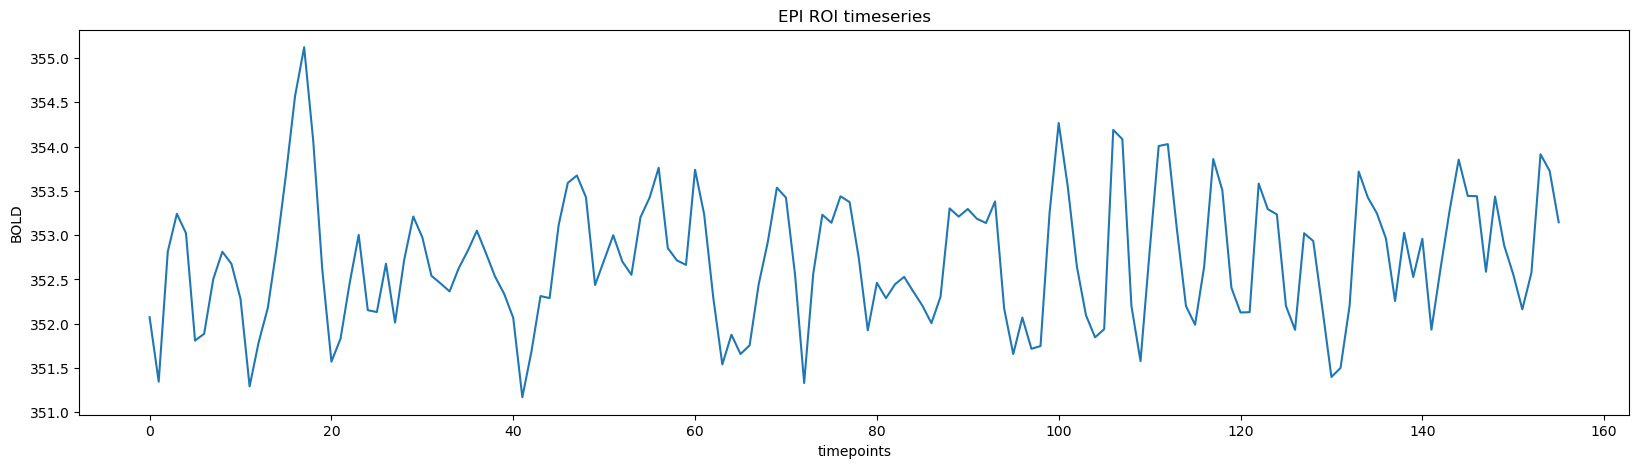

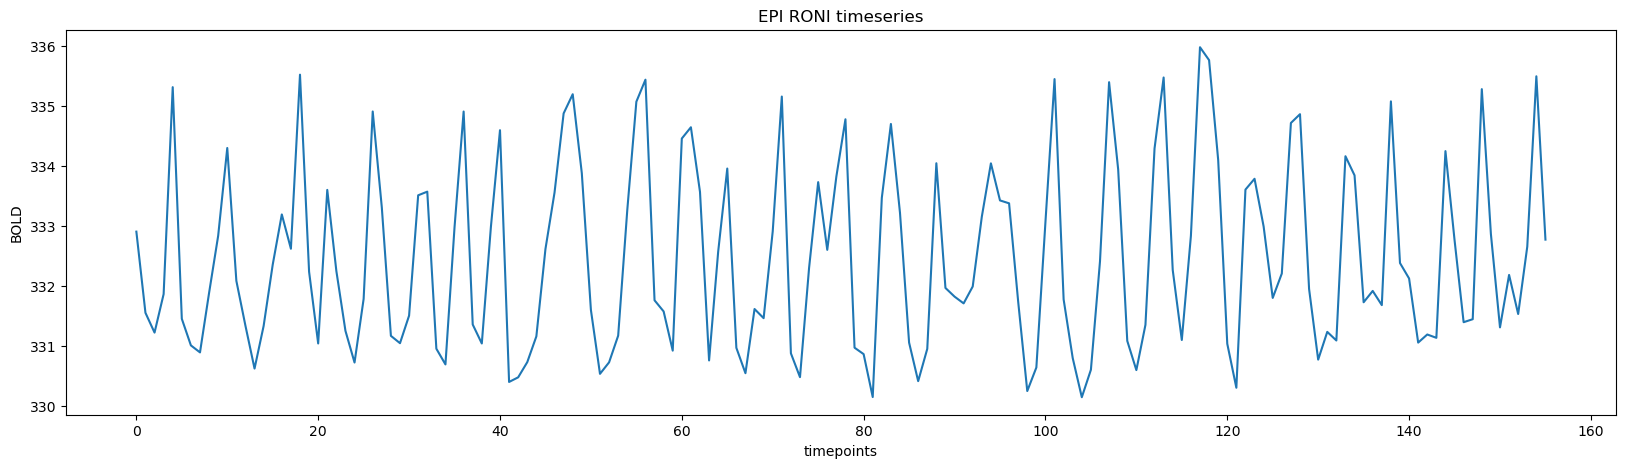

In [18]:
plot_timeseries(epi,gm,cf)

Text(0.5, 1.0, "['aCompCor01', 'aCompCor02', 'aCompCor03', 'aCompCor04', 'aCompCor05']")

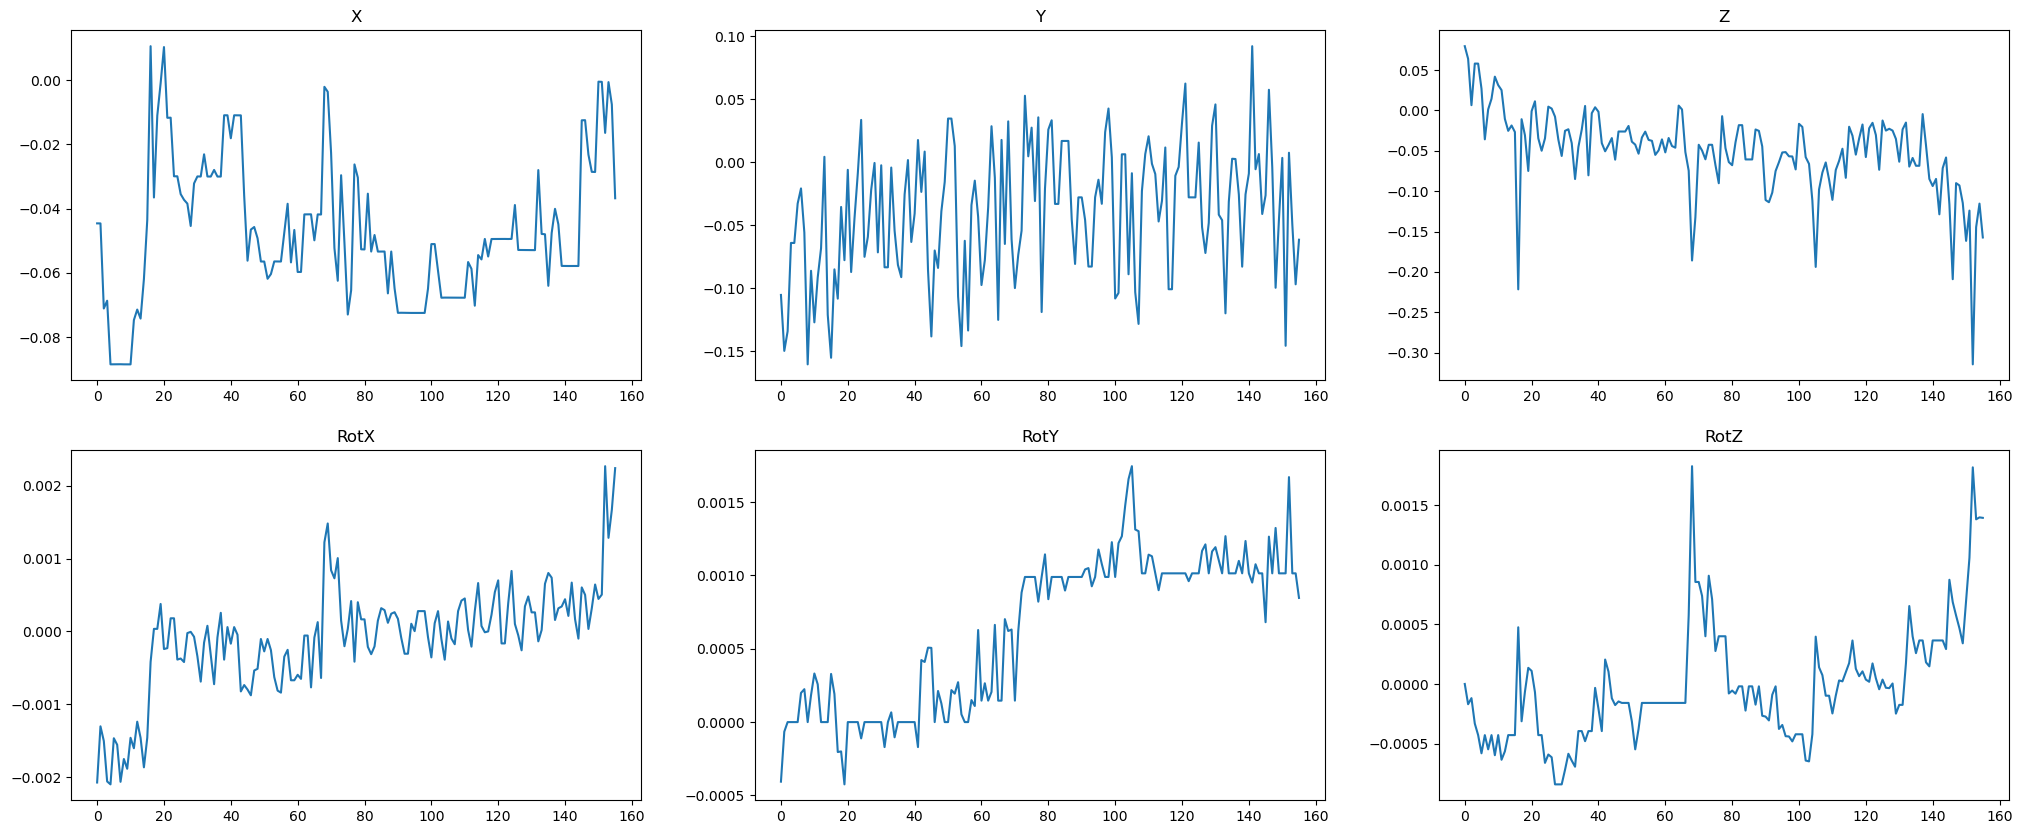

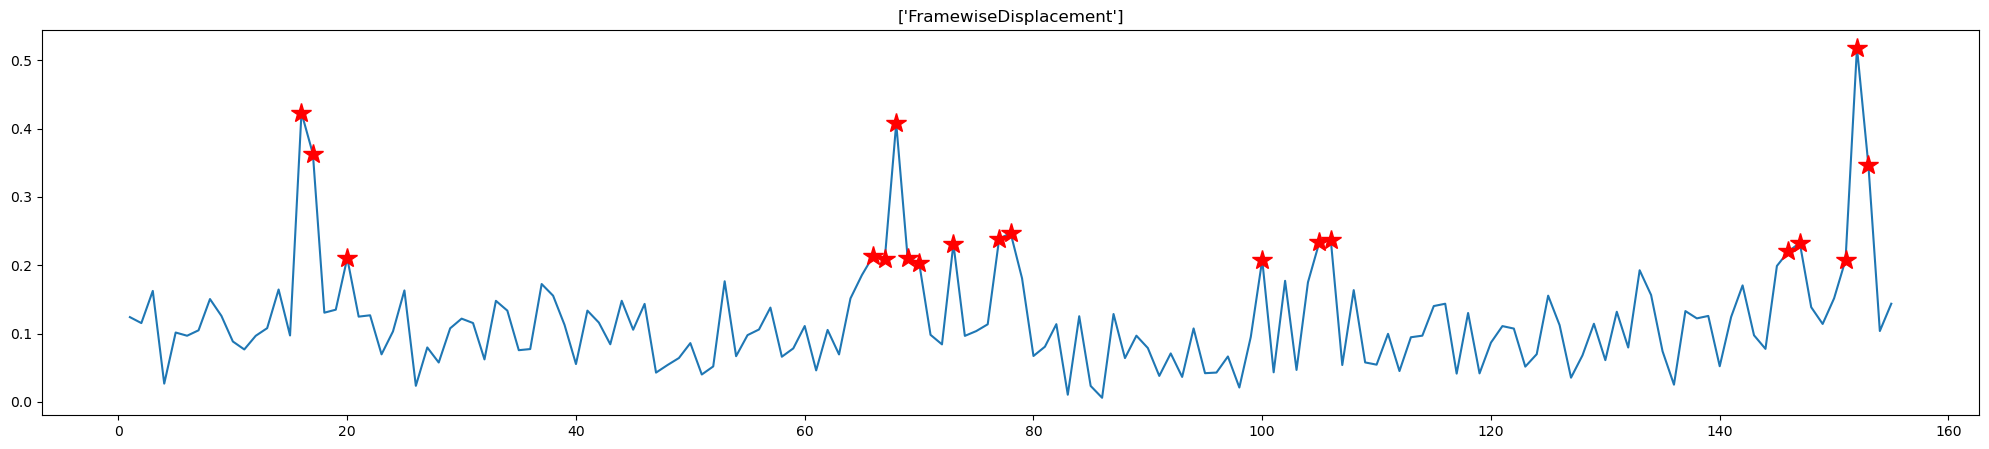

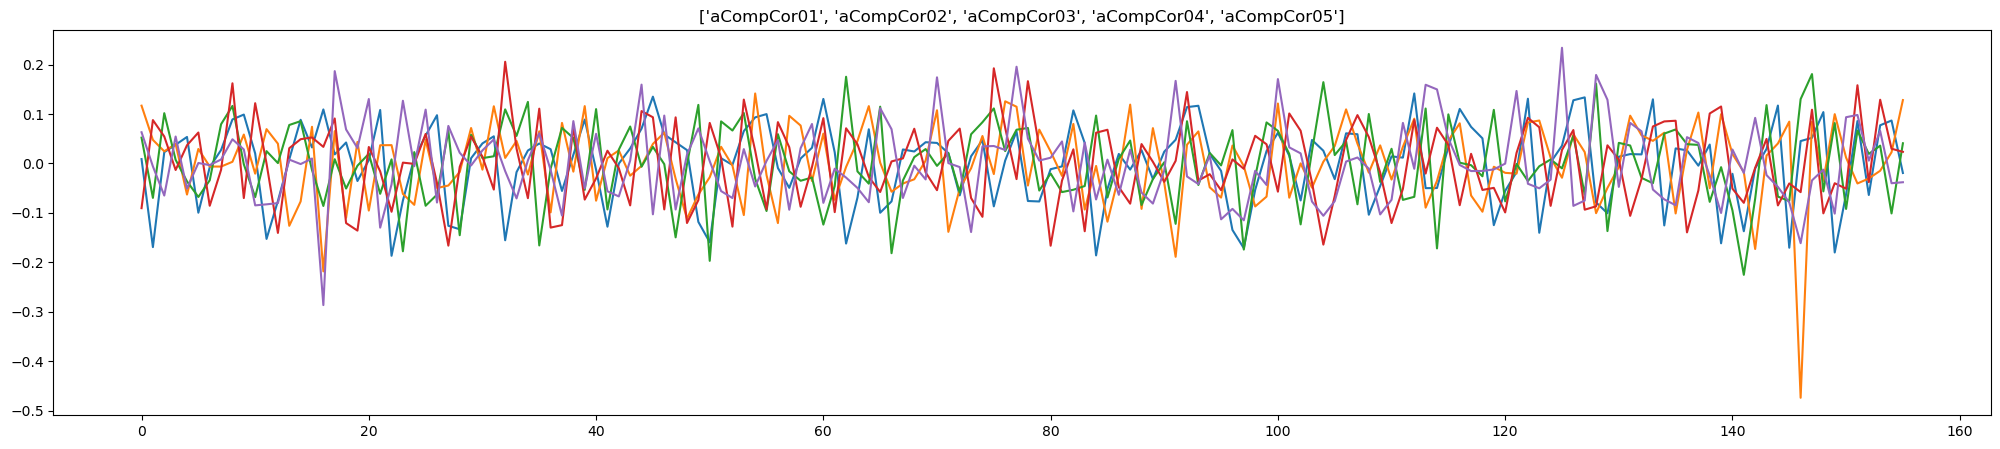

In [19]:
#conf_keys = ['trans_x','trans_y','trans_z','rot_x','rot_y','rot_z']
conf_keys = ['X','Y','Z','RotX','RotY','RotZ']
plt.figure(figsize=(25,10))
nrows = 2
ncols = 3
sp=0
for key in conf_keys:
    sp=sp+1;plt.subplot(nrows,ncols,sp)
    plt.plot(df_conf[key].values)
    plt.title(key)
    
plt.figure(figsize=(25,5))
#conf_keys = ['framewise_displacement']
conf_keys = ['FramewiseDisplacement']
plt.plot(df_conf[conf_keys].values)
thresh=.2
vec = (df_conf[conf_keys].values>thresh)*1.0*df_conf[conf_keys].values
vec[vec==0]=np.nan
plt.plot(vec,'r*',markersize=15)
plt.title(conf_keys)

plt.figure(figsize=(25,5))
#conf_keys = ['a_comp_cor_01','a_comp_cor_02',  'a_comp_cor_03',  'a_comp_cor_04','a_comp_cor_05']
conf_keys = ['aCompCor01','aCompCor02',  'aCompCor03',  'aCompCor04','aCompCor05']
plt.plot(df_conf[conf_keys].values)
plt.title(conf_keys)

In [20]:
def get_brain_signal(model,train_inputs,epi,gm,inv_z_score=True):
    model.eval()
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    nTR = epi.shape[-1]
    epi_flat = epi.numpy().reshape(-1,nTR)
    gm_flat = gm.numpy().flatten()
    
    train_in_coords = torch.utils.data.DataLoader(train_inputs, batch_size=batch_size, shuffle=False, num_workers=1, drop_last=False)
    dataloader_iter_in = iter(train_in_coords)
    brain_signals = []
    for _ in range(len(train_in_coords)):
        inputs_gm, inputs_cf = next(dataloader_iter_in)
        inputs_gm = inputs_gm.float().to(device)
        fg_signal = model.forward(inputs_gm)[0].detach().cpu().numpy()
        fg_signal = fg_signal[:,0:epi.shape[-1]]
        brain_signals.append(fg_signal)
    
    # Reconstruct the full brain array
    brain_signals_arr = np.zeros(epi_flat.shape)
    assert np.vstack(brain_signals).shape[0]==gm_flat.sum(), 'mismatch in voxel sizes: {}/{}'.format(np.vstack(brain_signals).shape[0],gm_flat.sum())
    
    brain_signals = np.vstack(brain_signals)
    
    if inv_z_score==True:
        epi_mean = epi_flat[gm_flat==1,:].mean(axis=1)
        epi_std = epi_flat[gm_flat==1,:].std(axis=1)
        brain_signals = (brain_signals*epi_std[:,np.newaxis]+epi_mean[:,np.newaxis]) # Invert z-scoring
        
    valid_voxels = gm_flat==1
    brain_signals_arr[valid_voxels, :] = brain_signals
    brain_signals_arr = brain_signals_arr.reshape(epi.shape)
    brain_signals_img = epi.new_image_like(brain_signals_arr)

    return brain_signals_img

In [21]:
obs_list_coords,noi_list_coords,gm,cf = get_obs_noi_list_coords(epi,gm,cf)

obs_list_coords.shape: (42574, 4, 156)
noi_list_coords.shape: (9337, 4, 156)
upsampling noi_list_coords
obs_list_coords.shape: (42574, 4, 156)
noi_list_coords.shape: (42574, 4, 156)


In [22]:
compcor = calc_and_save_compcor(epi,gm,cf,os.path.join(ofdir,f'compcor_S{s}_R{r}.nii.gz'),n_components=5,return_img=True)
array_to_brain(obs_list_coords[:,0,:],epi,gm,os.path.join(ofdir,f'preproc_S{s}_R{r}.nii.gz'),inv_z_score=True,return_img=False)

In [23]:
# Run some sanity check, for flat voxels (not good for training) and NaNs
assert np.isnan(obs_list_coords).sum()==0, 'NaNs in obs_list_coords'
assert np.isnan(noi_list_coords).sum()==0, 'NaNs in noi_list_coords'
assert (obs_list_coords[:,0,:].std(axis=-1)<1e-3).sum()==0,'Std0 in obs_list_coords'
assert (noi_list_coords[:,0,:].std(axis=-1)<1e-3).sum()==0,'Std0 in noi_list_coords'

In [24]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [25]:
import traceback

nrep = hyperparams_cvae.get('nrep',20)
nreps = nrep
epoch_num = hyperparams_cvae.get('epoch_num',100)
n_epochs = epoch_num
batch_size = hyperparams_cvae.get('batch_size',512)
latent_dim = hyperparams_cvae.get('latent_dim',(8,8))
beta = hyperparams_cvae.get('beta',0.01)       
gamma = hyperparams_cvae.get('gamma',0)       
delta = hyperparams_cvae.get('delta',0)       
lr = hyperparams_cvae.get('lr',0.001)

In [26]:
import models
import utils
import datasets
import dashboard

In [27]:
# aname = 'conv_denoise'
# n_epochs = 100
# for rep in range(nreps):
#     torch.cuda.empty_cache()
#     torch.cuda.init()
    
#     train_inputs = TrainDataset(obs_list_coords,noi_list_coords)
#     train_in = torch.utils.data.DataLoader(train_inputs, batch_size=batch_size,shuffle=True, num_workers=1,drop_last=True)
    
#     model = models.Conv1Ddenoise(input_channels = 4)   # need to add the last layer to rebuild the original size
#     model.to(device);
#     optimizer = optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)
    
#     track = {}
#     loss_L = []
#     loss_signal_L = []
#     loss_noise_L = []
#     for epoch in range(n_epochs):  # loop over the dataset multiple times    
#         dataloader_iter_in = iter(train_in)
#         running_loss = 0
#         running_loss_signal = 0
#         running_loss_noise = 0
#         for i in range(len(train_in)):           
#             optimizer.zero_grad()
#             inputs_gm,inputs_cf = next(dataloader_iter_in)
#             inputs_gm = inputs_gm.float().to(device)
#             inputs_cf = inputs_cf.float().to(device)[:,0,:]
#             [sig, noise] = model.forward(inputs_gm)
#             loss_ncc,loss_signal_ncc,loss_noise_ncc = model.loss_ncc(inputs_gm[:,0,:],inputs_cf,sig[:,0:epi.shape[-1]],noise[:,0:epi.shape[-1]])
#             loss_mse,loss_signal_mse,loss_noise_mse = model.loss_function(inputs_gm[:,0,:],inputs_cf,sig[:,0:epi.shape[-1]],noise[:,0:epi.shape[-1]])
#             loss = loss_ncc+loss_mse
#             loss_signal = loss_signal_ncc+loss_signal_mse
#             loss_noise = loss_noise_ncc+loss_noise_mse
#             if np.isnan(loss.detach().cpu().numpy()):
#                 print('loss is NaN')
#                 break
#             loss.backward()
#             optimizer.step()
#             running_loss += loss
#             running_loss_signal += loss_signal
#             running_loss_noise += loss_noise        
#         epoch_loss = running_loss / len(train_in)
#         epoch_loss_signal = running_loss_signal / len(train_in)
#         epoch_loss_noise = running_loss_noise / len(train_in)
#         loss_L.append(epoch_loss.detach().cpu().numpy())
#         loss_signal_L.append(epoch_loss_signal.detach().cpu().numpy())
#         loss_noise_L.append(epoch_loss_noise.detach().cpu().numpy())
#         track['loss_L'] = loss_L
#         track['loss_signal_L'] = loss_signal_L
#         track['loss_noise_L'] = loss_noise_L
    
#         brain_signal = get_brain_signal(model,train_inputs,epi,gm)
#         brain_signal.to_filename(os.path.join(ofdir,f'{aname}_signal_S{s}_R{r}_rep_{rep}.nii.gz'))
#         save_track(os.path.join(ofdir,f'{aname}_track_S{s}_R{r}_rep_{rep}.nii.gz'),track)

# signal_files = [os.path.join(ofdir,f) for f in os.listdir(ofdir) if all((f.startswith(f'{aname}_signal_S{s}_R{r}_rep_'),f.endswith('.nii.gz')))]
# print('Ensemble of {} repetitions'.format(len(signal_files)))
# signals_averaged = average_signal_ensemble(signal_files,os.path.join(ofdir,f'{aname}_signal_S{s}_R{r}_avg.nii.gz'))

# for analysis_spec in correlation_analyses:
#     analysis_spec['filename']=analysis_spec['filename_temp'].format(s=s,r=r,aname=aname)
#     run_correlation_analysis_from_spec(analysis_spec,epi,compcor,signals_averaged,gm)

# for analysis_spec in contrast_analyses:
#     analysis_spec['filename']=analysis_spec['filename_temp'].format(s=s,r=r,aname=aname)
#     run_contrast_analysis_from_spec(analysis_spec,epi,compcor,signals_averaged,gm)

100%|█████████████████████████████████████████████| 5/5 [00:14<00:00,  2.99s/it]


In [ ]:
# aname = 'conv_denoise_long'
# n_epochs = 200
# for rep in range(nreps):
#     torch.cuda.empty_cache()
#     torch.cuda.init()
    
#     train_inputs = TrainDataset(obs_list_coords,noi_list_coords)
#     train_in = torch.utils.data.DataLoader(train_inputs, batch_size=batch_size,shuffle=True, num_workers=1,drop_last=True)
    
#     model = models.Conv1Ddenoise(input_channels = 4)   # need to add the last layer to rebuild the original size
#     model.to(device);
#     optimizer = optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)
    
#     track = {}
#     loss_L = []
#     loss_signal_L = []
#     loss_noise_L = []
#     for epoch in range(n_epochs):  # loop over the dataset multiple times    
#         dataloader_iter_in = iter(train_in)
#         running_loss = 0
#         running_loss_signal = 0
#         running_loss_noise = 0
#         for i in range(len(train_in)):           
#             optimizer.zero_grad()
#             inputs_gm,inputs_cf = next(dataloader_iter_in)
#             inputs_gm = inputs_gm.float().to(device)
#             inputs_cf = inputs_cf.float().to(device)[:,0,:]
#             [sig, noise] = model.forward(inputs_gm)
#             loss_ncc,loss_signal_ncc,loss_noise_ncc = model.loss_ncc(inputs_gm[:,0,:],inputs_cf,sig[:,0:epi.shape[-1]],noise[:,0:epi.shape[-1]])
#             loss_mse,loss_signal_mse,loss_noise_mse = model.loss_function(inputs_gm[:,0,:],inputs_cf,sig[:,0:epi.shape[-1]],noise[:,0:epi.shape[-1]])
#             loss = loss_ncc+loss_mse
#             loss_signal = loss_signal_ncc+loss_signal_mse
#             loss_noise = loss_noise_ncc+loss_noise_mse
#             if np.isnan(loss.detach().cpu().numpy()):
#                 print('loss is NaN')
#                 break
#             loss.backward()
#             optimizer.step()
#             running_loss += loss
#             running_loss_signal += loss_signal
#             running_loss_noise += loss_noise        
#         epoch_loss = running_loss / len(train_in)
#         epoch_loss_signal = running_loss_signal / len(train_in)
#         epoch_loss_noise = running_loss_noise / len(train_in)
#         loss_L.append(epoch_loss.detach().cpu().numpy())
#         loss_signal_L.append(epoch_loss_signal.detach().cpu().numpy())
#         loss_noise_L.append(epoch_loss_noise.detach().cpu().numpy())
#         track['loss_L'] = loss_L
#         track['loss_signal_L'] = loss_signal_L
#         track['loss_noise_L'] = loss_noise_L
    
#         brain_signal = get_brain_signal(model,train_inputs,epi,gm)
#         brain_signal.to_filename(os.path.join(ofdir,f'{aname}_signal_S{s}_R{r}_rep_{rep}.nii.gz'))
#         save_track(os.path.join(ofdir,f'{aname}_track_S{s}_R{r}_rep_{rep}.nii.gz'),track)


# signal_files = [os.path.join(ofdir,f) for f in os.listdir(ofdir) if all((f.startswith(f'{aname}_signal_S{s}_R{r}_rep_'),f.endswith('.nii.gz')))]
# print('Ensemble of {} repetitions'.format(len(signal_files)))
# signals_averaged = average_signal_ensemble(signal_files,os.path.join(ofdir,f'{aname}_signal_S{s}_R{r}_avg.nii.gz'))

# for analysis_spec in correlation_analyses:
#     analysis_spec['filename']=analysis_spec['filename_temp'].format(s=s,r=r,aname=aname)
#     run_correlation_analysis_from_spec(analysis_spec,epi,compcor,signals_averaged,gm)

# for analysis_spec in contrast_analyses:
#     analysis_spec['filename']=analysis_spec['filename_temp'].format(s=s,r=r,aname=aname)
#     run_contrast_analysis_from_spec(analysis_spec,epi,compcor,signals_averaged,gm)

In [54]:
aname = 'conv_denoise_large'
n_epochs = 100
for rep in range(nreps):
    torch.cuda.empty_cache()
    torch.cuda.init()
    
    train_inputs = TrainDataset(obs_list_coords,noi_list_coords)
    train_in = torch.utils.data.DataLoader(train_inputs, batch_size=batch_size,shuffle=True, num_workers=1,drop_last=True)
    
    model = models.Conv1Ddenoise_large(input_channels = 4)   # need to add the last layer to rebuild the original size
    model.to(device);
    optimizer = optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)
    
    track = {}
    loss_L = []
    loss_signal_L = []
    loss_noise_L = []
    for epoch in range(n_epochs):  # loop over the dataset multiple times    
        dataloader_iter_in = iter(train_in)
        running_loss = 0
        running_loss_signal = 0
        running_loss_noise = 0
        for i in range(len(train_in)):           
            optimizer.zero_grad()
            inputs_gm,inputs_cf = next(dataloader_iter_in)
            inputs_gm = inputs_gm.float().to(device)
            inputs_cf = inputs_cf.float().to(device)[:,0,:]
            [sig, noise] = model.forward(inputs_gm)
            loss_ncc,loss_signal_ncc,loss_noise_ncc = model.loss_ncc(inputs_gm[:,0,:],inputs_cf,sig[:,0:epi.shape[-1]],noise[:,0:epi.shape[-1]])
            loss_mse,loss_signal_mse,loss_noise_mse = model.loss_function(inputs_gm[:,0,:],inputs_cf,sig[:,0:epi.shape[-1]],noise[:,0:epi.shape[-1]])
            loss = loss_ncc+loss_mse
            loss_signal = loss_signal_ncc+loss_signal_mse
            loss_noise = loss_noise_ncc+loss_noise_mse
            if np.isnan(loss.detach().cpu().numpy()):
                print('loss is NaN')
                break
            loss.backward()
            optimizer.step()
            running_loss += loss
            running_loss_signal += loss_signal
            running_loss_noise += loss_noise        
        epoch_loss = running_loss / len(train_in)
        epoch_loss_signal = running_loss_signal / len(train_in)
        epoch_loss_noise = running_loss_noise / len(train_in)
        loss_L.append(epoch_loss.detach().cpu().numpy())
        loss_signal_L.append(epoch_loss_signal.detach().cpu().numpy())
        loss_noise_L.append(epoch_loss_noise.detach().cpu().numpy())
        track['loss_L'] = loss_L
        track['loss_signal_L'] = loss_signal_L
        track['loss_noise_L'] = loss_noise_L
    
        brain_signal = get_brain_signal(model,train_inputs,epi,gm)
        brain_signal.to_filename(os.path.join(ofdir,f'{aname}_signal_S{s}_R{r}_rep_{rep}.nii.gz'))
        save_track(os.path.join(ofdir,f'{aname}_track_S{s}_R{r}_rep_{rep}.nii.gz'),track)

signal_files = [os.path.join(ofdir,f) for f in os.listdir(ofdir) if all((f.startswith(f'{aname}_signal_S{s}_R{r}_rep_'),f.endswith('.nii.gz')))]
print('Ensemble of {} repetitions'.format(len(signal_files)))
signals_averaged = average_signal_ensemble(signal_files,os.path.join(ofdir,f'{aname}_signal_S{s}_R{r}_avg.nii.gz'))

for analysis_spec in correlation_analyses:
    analysis_spec['filename']=analysis_spec['filename_temp'].format(s=s,r=r,aname=aname)
    run_correlation_analysis_from_spec(analysis_spec,epi,compcor,signals_averaged,gm)

for analysis_spec in contrast_analyses:
    analysis_spec['filename']=analysis_spec['filename_temp'].format(s=s,r=r,aname=aname)
    run_contrast_analysis_from_spec(analysis_spec,epi,compcor,signals_averaged,gm)

KeyboardInterrupt: 

In [56]:
# aname = 'conv_denoise_smooth'
# n_epochs = 100
# for rep in range(nreps):
#     torch.cuda.empty_cache()
#     torch.cuda.init()
    
#     train_inputs = TrainDataset(obs_list_coords,noi_list_coords)
#     train_in = torch.utils.data.DataLoader(train_inputs, batch_size=batch_size,shuffle=True, num_workers=1,drop_last=True)
    
#     model = models.Conv1Ddenoise(input_channels = 4)   # need to add the last layer to rebuild the original size
#     model.to(device);
#     optimizer = optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)
    
#     track = {}
#     loss_L = []
#     loss_signal_L = []
#     loss_noise_L = []
#     for epoch in range(n_epochs):  # loop over the dataset multiple times    
#         dataloader_iter_in = iter(train_in)
#         running_loss = 0
#         running_loss_signal = 0
#         running_loss_noise = 0
#         for i in range(len(train_in)):           
#             optimizer.zero_grad()
#             inputs_gm,inputs_cf = next(dataloader_iter_in)
#             inputs_gm = inputs_gm.float().to(device)
#             inputs_cf = inputs_cf.float().to(device)[:,0,:]
#             [sig, noise] = model.forward(inputs_gm)
#             loss_ncc,loss_signal_ncc,loss_noise_ncc = model.loss_ncc(inputs_gm[:,0,:],inputs_cf,sig[:,0:epi.shape[-1]],noise[:,0:epi.shape[-1]])
#             loss_mse,loss_signal_mse,loss_noise_mse = model.loss_function(inputs_gm[:,0,:],inputs_cf,sig[:,0:epi.shape[-1]],noise[:,0:epi.shape[-1]])
#             smoothness_loss = model.smoothness_loss(sig[:,0:epi.shape[-1]])
#             loss = loss_ncc+loss_mse+0.01*smoothness_loss
#             loss_signal = loss_signal_ncc+loss_signal_mse
#             loss_noise = loss_noise_ncc+loss_noise_mse
#             if np.isnan(loss.detach().cpu().numpy()):
#                 print('loss is NaN')
#                 break
#             loss.backward()
#             optimizer.step()
#             running_loss += loss
#             running_loss_signal += loss_signal
#             running_loss_noise += loss_noise        
#         epoch_loss = running_loss / len(train_in)
#         epoch_loss_signal = running_loss_signal / len(train_in)
#         epoch_loss_noise = running_loss_noise / len(train_in)
#         loss_L.append(epoch_loss.detach().cpu().numpy())
#         loss_signal_L.append(epoch_loss_signal.detach().cpu().numpy())
#         loss_noise_L.append(epoch_loss_noise.detach().cpu().numpy())
#         track['loss_L'] = loss_L
#         track['loss_signal_L'] = loss_signal_L
#         track['loss_noise_L'] = loss_noise_L
    
#         brain_signal = get_brain_signal(model,train_inputs,epi,gm)
#         brain_signal.to_filename(os.path.join(ofdir,f'{aname}_signal_S{s}_R{r}_rep_{rep}.nii.gz'))
#         save_track(os.path.join(ofdir,f'{aname}_track_S{s}_R{r}_rep_{rep}.nii.gz'),track)

# signal_files = [os.path.join(ofdir,f) for f in os.listdir(ofdir) if all((f.startswith(f'{aname}_signal_S{s}_R{r}_rep_'),f.endswith('.nii.gz')))]
# print('Ensemble of {} repetitions'.format(len(signal_files)))
# signals_averaged = average_signal_ensemble(signal_files,os.path.join(ofdir,f'{aname}_signal_S{s}_R{r}_avg.nii.gz'))

# for analysis_spec in correlation_analyses:
#     analysis_spec['filename']=analysis_spec['filename_temp'].format(s=s,r=r,aname=aname)
#     run_correlation_analysis_from_spec(analysis_spec,epi,compcor,signals_averaged,gm)

# for analysis_spec in contrast_analyses:
#     analysis_spec['filename']=analysis_spec['filename_temp'].format(s=s,r=r,aname=aname)
#     run_contrast_analysis_from_spec(analysis_spec,epi,compcor,signals_averaged,gm)

KeyboardInterrupt: 

In [58]:
# aname = 'conv_denoise_unet'
# n_epochs = 100
# for rep in range(nreps):
#     torch.cuda.empty_cache()
#     torch.cuda.init()
    
#     train_inputs = TrainDataset(obs_list_coords,noi_list_coords)
#     train_in = torch.utils.data.DataLoader(train_inputs, batch_size=batch_size,shuffle=True, num_workers=1,drop_last=True)
    
#     model = models.Conv1DUnet_denoise(input_channels = 4)   # need to add the last layer to rebuild the original size
#     model.to(device);
#     optimizer = optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)
    
#     track = {}
#     loss_L = []
#     loss_signal_L = []
#     loss_noise_L = []
#     for epoch in range(n_epochs):  # loop over the dataset multiple times    
#         dataloader_iter_in = iter(train_in)
#         running_loss = 0
#         running_loss_signal = 0
#         running_loss_noise = 0
#         for i in range(len(train_in)):           
#             optimizer.zero_grad()
#             inputs_gm,inputs_cf = next(dataloader_iter_in)
#             inputs_gm = inputs_gm.float().to(device)
#             inputs_cf = inputs_cf.float().to(device)[:,0,:]
#             [sig, noise] = model.forward(inputs_gm)
#             loss_ncc,loss_signal_ncc,loss_noise_ncc = model.loss_ncc(inputs_gm[:,0,:],inputs_cf,sig[:,0:epi.shape[-1]],noise[:,0:epi.shape[-1]])
#             loss_mse,loss_signal_mse,loss_noise_mse = model.loss_function(inputs_gm[:,0,:],inputs_cf,sig[:,0:epi.shape[-1]],noise[:,0:epi.shape[-1]])
#             loss = loss_ncc+loss_mse
#             loss_signal = loss_signal_ncc+loss_signal_mse
#             loss_noise = loss_noise_ncc+loss_noise_mse
#             if np.isnan(loss.detach().cpu().numpy()):
#                 print('loss is NaN')
#                 break
#             loss.backward()
#             optimizer.step()
#             running_loss += loss
#             running_loss_signal += loss_signal
#             running_loss_noise += loss_noise        
#         epoch_loss = running_loss / len(train_in)
#         epoch_loss_signal = running_loss_signal / len(train_in)
#         epoch_loss_noise = running_loss_noise / len(train_in)
#         loss_L.append(epoch_loss.detach().cpu().numpy())
#         loss_signal_L.append(epoch_loss_signal.detach().cpu().numpy())
#         loss_noise_L.append(epoch_loss_noise.detach().cpu().numpy())
#         track['loss_L'] = loss_L
#         track['loss_signal_L'] = loss_signal_L
#         track['loss_noise_L'] = loss_noise_L
    
#         brain_signal = get_brain_signal(model,train_inputs,epi,gm)
#         brain_signal.to_filename(os.path.join(ofdir,f'{aname}_signal_S{s}_R{r}_rep_{rep}.nii.gz'))
#         save_track(os.path.join(ofdir,f'{aname}_track_S{s}_R{r}_rep_{rep}.nii.gz'),track)

# signal_files = [os.path.join(ofdir,f) for f in os.listdir(ofdir) if all((f.startswith(f'{aname}_signal_S{s}_R{r}_rep_'),f.endswith('.nii.gz')))]
# print('Ensemble of {} repetitions'.format(len(signal_files)))
# signals_averaged = average_signal_ensemble(signal_files,os.path.join(ofdir,f'{aname}_signal_S{s}_R{r}_avg.nii.gz'))

# for analysis_spec in correlation_analyses:
#     analysis_spec['filename']=analysis_spec['filename_temp'].format(s=s,r=r,aname=aname)
#     run_correlation_analysis_from_spec(analysis_spec,epi,compcor,signals_averaged,gm)

# for analysis_spec in contrast_analyses:
#     analysis_spec['filename']=analysis_spec['filename_temp'].format(s=s,r=r,aname=aname)
#     run_contrast_analysis_from_spec(analysis_spec,epi,compcor,signals_averaged,gm)

KeyboardInterrupt: 